# **VTuber 1B: Superchats Analysis**

VTuber 1B is a large-scale dataset designed for academic research, containing over a billion live chats, superchats (donations), and moderation events (such as bans and deletions) from virtual YouTubers' live streams. Our analysis will focus specifically on superchats during the month of March 2022. The goal of this research is to explore key patterns and trends within the data and address several research questions related to viewer interactions, donations, and moderation in the VTuber community.

The link to the dataset is here: https://www.kaggle.com/datasets/uetchy/vtuber-livechat?resource=download&select=superchats_2021-03.parquet

# Loading and Curing Data

In [ ]:
#comment
# Importing necessary libraries

import pandas as pd  # For handling data
from glob import iglob  # To find files matching a pattern
import networkx as nx  # For creating and analyzing graphs
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical calculations
import math  # For math operations
from datetime import datetime  # For working with dates and times
from datetime import date
from networkx.algorithms import community
import itertools

# Install the CurrencyConverter library if not already installed
!pip install currencyconverter

# Import the currency converter and set it up
from currency_converter import CurrencyConverter
from currency_converter import RateNotFoundError
currencyConverter = CurrencyConverter(fallback_on_missing_rate=True)  # Uses closest rates if needed

In [ ]:
# Combine all Parquet files matching the pattern 'superchats_*.parquet' into a single DataFrame

def dataset_converter(parquet):
  sc = pd.concat([
      pd.read_parquet(f)  # Read each Parquet file
      for f in iglob(parquet)  # Find all matching files
  ], ignore_index=False)  # Keep the original indices

# Sort the DataFrame by its index
  sc.sort_index(inplace=True)

  return sc


sc = dataset_converter('/content/superchats_2021-03.parquet')

# An array containing all datasets
datasets = []

# We go though every file in /content/ and load the datasets into the datasets array
for file in iglob('/content/superchats_*.parquet'):

  # Getting the file name of which file is being loaded and parsing out the year and month for the data
  filename = open(file).name
  year = int((filename.split("/content/superchats_")[1]).split(".parquet")[0].split("-")[0])
  month = int((filename.split("/content/superchats_")[1]).split(".parquet")[0].split("-")[1])
  datasets.append({
      "data": pd.read_parquet(file),
      "filename": filename,
      "date": date(year, month, 1)
      })

# Sort the dataset making sure index 0 is the first month
datasets = sorted(datasets, key=lambda item: item["date"], reverse=False)

#print(sc.head)
print(datasets[0]["data"].head)
print(datasets[0]["filename"])
print(datasets[0]["date"])

<bound method NDFrame.head of                                timestamp  amount currency  significance  \
0       2021-03-15T23:20:10.481000+00:00     500      JPY             3   
1       2021-03-15T23:20:11.441000+00:00     610      JPY             3   
2       2021-03-15T23:20:37.449000+00:00     200      JPY             2   
3       2021-03-15T23:20:43.266000+00:00    2000      JPY             5   
4       2021-03-15T23:20:54.710000+00:00    1000      JPY             4   
...                                  ...     ...      ...           ...   
127640  2021-03-31T23:57:59.593000+00:00     500      JPY             3   
127641  2021-03-31T23:58:16.964000+00:00     500      JPY             3   
127642  2021-03-31T23:58:38.390000+00:00     200      JPY             2   
127643  2021-03-31T23:59:20.657000+00:00     500      JPY             3   
127644  2021-03-31T23:59:46.165000+00:00     500      JPY             3   

                                 authorChannelId      videoId  \
0   

In [ ]:
# Print the total number of unique Patreon authors
print("Total unique patreons:", len(sc.authorChannelId.unique()))

# Print the total number of unique channels
print("Total Channels:", len(sc.channelId.unique()))

Total unique patreons: 37894
Total Channels: 321


# Currency Conversion


In [ ]:
# Predefined fallback exchange rates for unsupported currencies
exchange_rates = {
    'JPY': 0.0065, 'TWD': 0.0310, 'HKD': 0.1286, 'CAD': 0.7186, 'PHP': 0.0171, 'EUR': 1.0713, 'SGD': 0.7530, 'GBP': 1.2910, 'AUD': 0.6576, 'RUB': 0.0102, 'KRW': 0.0007, 'MXN': 0.0495,
    'BRL': 0.1742, 'ARS': 0.0010, 'CLP': 0.0010, 'SEK': 0.0923, 'INR': 0.0118, 'PLN': 0.2474, 'NZD': 0.5957, 'PEN': 0.2657, 'NOK': 0.0908, 'DKK': 0.1436, 'HUF': 0.0026, 'CHF': 1.1412,
    'CZK': 0.0424, 'HRK': 1.0713, 'COP': 0.0002, 'BGN': 0.5477, 'HNL': 0.0397, 'ISK': 0.0072, 'CRC': 0.0072, 'RON': 0.2152, 'ZAR': 0.0567, 'GTQ': 0.1293, 'BYN': 0.3057, 'RSD': 0.0091,
    'BOB': 0.0091, 'UYU': 0.0239, 'DOP': 0.0165, 'MKD': 0.0174,
}

# Function to convert donation amounts to USD
def convert_to_usd(row):
    try:
        # Try converting using the currency converter with the donation timestamp
        return currencyConverter.convert(row["amount"], row["currency"], "USD", datetime.fromisoformat(str(row["timestamp"])))

    except (ValueError, RateNotFoundError) as e:  # Fallback for unsupported currencies
        rate = exchange_rates.get(row["currency"], 1)  # Get the fallback rate, default is 1 (same value)
        return row['amount'] * rate  # Convert using fallback rate

# Apply the conversion to each row in the DataFrame and store the result in a new column

# Applying the currency conversion to all datasets
for dataset in datasets:
  dataset["data"]['amount_in_usd'] = dataset["data"].apply(convert_to_usd, axis=1).round(2)

sc['amount_in_usd'] = sc.apply(convert_to_usd, axis=1)

# Round the 'amount_in_usd' column to 2 decimal places
sc['amount_in_usd'] = sc['amount_in_usd'].round(2)

# Print the first few rows of the updated DataFrame
print(sc.head)

<bound method NDFrame.head of                                timestamp  amount currency  significance  \
0       2021-03-15T23:20:10.481000+00:00     500      JPY             3   
1       2021-03-15T23:20:11.441000+00:00     610      JPY             3   
2       2021-03-15T23:20:37.449000+00:00     200      JPY             2   
3       2021-03-15T23:20:43.266000+00:00    2000      JPY             5   
4       2021-03-15T23:20:54.710000+00:00    1000      JPY             4   
...                                  ...     ...      ...           ...   
127640  2021-03-31T23:57:59.593000+00:00     500      JPY             3   
127641  2021-03-31T23:58:16.964000+00:00     500      JPY             3   
127642  2021-03-31T23:58:38.390000+00:00     200      JPY             2   
127643  2021-03-31T23:59:20.657000+00:00     500      JPY             3   
127644  2021-03-31T23:59:46.165000+00:00     500      JPY             3   

                                 authorChannelId      videoId  \
0   

# Building the graphs

In [ ]:
# Initialize a directed graph
def create_graph(data, limit=-1):
  graph = nx.DiGraph()

  # Dictionary to store total superchat amount per edge (authorChannelId -> channelId)
  superchat_edge_dictionary = {}

  # Dictionary to store attributes for edges (e.g., currency type and distance)
  attributes = {}

  # Loop through the superchat data (assuming sc is a DataFrame)
  for index, superchat in data.iterrows():
      # Check if an edge already exists, and if so, accumulate the donation amount
      if (superchat.authorChannelId, superchat.channelId) in superchat_edge_dictionary:
          superchat_edge_dictionary[(superchat.authorChannelId, superchat.channelId)] += superchat.amount_in_usd
      else:
          # If the edge doesn't exist, initialize the donation amount and set the edge attribute
          superchat_edge_dictionary[(superchat.authorChannelId, superchat.channelId)] = superchat.amount_in_usd
          attributes[(superchat.authorChannelId, superchat.channelId)] = {
              "currency": superchat.currency,
              # "distance": 1/superchat.amount (can be used if needed)
          }

      # Stop processing after 1000 rows (for testing purposes)
      if index == limit:
          break

  ### Add edges to the graph with the donation amount as the weight
  for edge, weight in superchat_edge_dictionary.items():
      graph.add_edge(edge[0], edge[1], weight=weight)

  # Calculate the distance for each edge: distance is the inverse of the total donation amount
  for index, (edge, value) in enumerate(attributes.items()):
      total_amount = superchat_edge_dictionary[edge]
      try:
        value["distance"] = 1 / total_amount  # Smaller amounts lead to larger distances
      except ZeroDivisionError:
        value["distane"] = 0

      attributes[edge] = value

  # Set all the attributes for the edges in the graph
  nx.set_edge_attributes(graph, attributes)

  return graph

# Will store the graphs for every dataset
graphs = []

limit = -1

# Go through every dataset and create graphs for the datasets and store them inthe graphs array
for dataset in datasets:
  graphs.append({
      "graph": create_graph(dataset["data"], limit),
      "filename": dataset["filename"],
      "date": dataset["date"]
      })


graph = create_graph(sc)

In [ ]:
# Set up figure size for the plot
def draw_graph(graph):
  plt.figure(figsize=(8, 6))

  # Define the positioning of nodes using the shell layout
  pos = nx.spring_layout(graph)

  # Draw the graph with nodes of size 50
  nx.draw(graph, pos, node_size=50)

  # Get the edge labels (weights) to display the donation amounts
  edge_labels = nx.get_edge_attributes(graph, 'weight')

  # Draw edge labels on the plot to display the weights
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

  # Show the plot
  plt.show()

for graph in graphs:
  draw_graph(graph["graph"])

# Find currency of best candidate

In [ ]:
# Function to find the "best candidate" node based on in-degree centrality

def top_in_candidate(G):
    # Calculate in-degree centrality for all nodes in the graph
    centrality = nx.in_degree_centrality(G)

    # Find the maximum centrality value
    top_10_gainers = sorted(centrality.items(), key=lambda item: item[1], reverse=True)[0:10]  # Return the node with the highest in-degree centrality

    return top_10_gainers

# Find and print the best candidate for having most donations in the graph
best_candidate_streamer = top_in_candidate(graph)
print("Best candidate:")
print(*best_candidate_streamer, sep='\n')

Best candidate:
('UCS9uQI-jC3DE0L4IpXyvr6w', 0.054090124038310566)
('UC1DCedRgGHBdm81E1llLhOQ', 0.030172188203276287)
('UCoSrY_IQQVpmIRZ9Xf-y93g', 0.028471240906474068)
('UCFKOVgVbGmX65RxO3EtH3iw', 0.027293662008687915)
('UCvzGlP9oQwU--Y0r9id_jnA', 0.02726749358873711)
('UCHsx4Hqa-1ORjQTh9TYDhww', 0.026168419950803372)
('UCqm3BQLlJfvkTsX_hvm0UmA', 0.02577589365154132)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.025723556811639712)
('UCL_qhgtOy0dy1Agp8vkySQg', 0.02436279897419794)
('UC1CfXB_kRs3C-zaeTG3oGyg', 0.023473072695870623)


In [ ]:
best_candidate_1step_edges = graph.in_edges(best_candidate_streamer) # Grab all the edges for the best_caindidate found above

print(graph.edges[next(iter(best_candidate_1step_edges))[0],next(iter(best_candidate_1step_edges))[1]]["currency"]) # This lines grabs the currency of the first edge in best_candidate_1step_edges. I had to use next(iter(best_candidate_1step_edges)) because the dev didn't implement using indexs like best_candidate_1step_edges[0] :(

In [ ]:
graph.in_degree(best_candidate_streamer[0])

InDegreeView({'UCS9uQI-jC3DE0L4IpXyvr6w': 2067})

In [ ]:
total_amount = sum(data['weight'] for _, _, data in graph.in_edges(best_candidate_streamer[0], data=True))
print(round(total_amount, 2))

87593.08


# Finding the most influencial donators

In [ ]:
# Function to find the "best candidate" node based on in-degree centrality
def top_out_candidate(G):
    # Calculate in-degree centrality for all nodes in the graph
    centrality = nx.out_degree_centrality(G)

    # Iterate through nodes to find the one with the maximum centrality
    top_10_gainers = sorted(centrality.items(), key=lambda item: item[1], reverse=True)[0:10]

    return top_10_gainers

# Find and print the best candidate for having most donations in the test graph
best_candidate_streamer = top_out_candidate(graph)
print("Best candidate:")
print(*best_candidate_streamer, sep='\n')

Best candidate:
('358aaddc52d77d586905d46da9fcc644ca72e75e', 0.001203747317736955)
('0d520b71c0fc01b9302d70ce21e15d14b051e039', 0.0005757052389176742)
('c1b69e599e63ef6c16fdb024be82317376d043df', 0.0005495368189668708)
('862f85a29fa903de2e3aa58497e166d136874e49', 0.0005495368189668708)
('9104d24076566282f8b19b05e0bf7fb78c7be4d6', 0.000497199979065264)
('86fc3699c144a81774bea74698ad3a9e74236238', 0.000497199979065264)
('0dd1fd96cc090ec6640159a00e09b5f909217b61', 0.000497199979065264)
('ba9c1c9823a7f0f84197d6130a354dfc1dbeb5db', 0.0004710315591144607)
('c28d774059ad51e0781db6e3e13b362f77b204c8', 0.0004448631391636573)
('bf9dc34c258c6db3ebbb3bd500be956f7f86834b', 0.00041869471921285393)


In [ ]:
graph.out_degree(best_candidate_streamer[0])

OutDegreeView({'358aaddc52d77d586905d46da9fcc644ca72e75e': 46})

In [ ]:
total_amount = sum(data['weight'] for _, _, data in graph.out_edges(best_candidate_streamer[0], data=True))
print(round(total_amount, 2))

272.67


# What is the most influential demograph

In [ ]:
# Count the occurrences of each currency type in the 'currency' column of the DataFrame
currency_counts = sc['currency'].value_counts()

# Print out the counts of each currency type
print("\nCurrency counts:")
print(currency_counts)


Currency counts:
currency
JPY    90315
USD    14289
TWD     7348
HKD     3324
CAD     2065
PHP     1669
EUR     1461
SGD     1268
GBP      972
AUD      939
RUB      834
KRW      562
MXN      477
BRL      385
ARS      320
CLP      220
SEK      186
INR      172
PLN      166
NZD      112
PEN      111
NOK       74
DKK       65
HUF       59
CHF       56
CZK       43
HRK       21
COP       21
BGN       15
HNL       13
ISK       12
CRC       12
RON       12
ZAR       11
GTQ        8
BYN        8
RSD        8
BOB        4
UYU        4
DOP        3
MKD        1
Name: count, dtype: int64


In [ ]:
demographic_counts = {}

for dataset in datasets:
  for index, superchat in dataset["data"].iterrows():
    #print(superchat["amount"], superchat["currency"])
    try:
      demographic_counts[superchat["currency"]] += superchat["amount_in_usd"]
    except KeyError:
      demographic_counts[superchat["currency"]] = 0


In [ ]:
demographic_counts["PYG"] = 0
for key, value in sorted(demographic_counts.items(), key=lambda item: item[1], reverse=True)[0:10]:
  print(key,value)

JPY 37940365.33002052
USD 5873280.88000924
TWD 3064894.400003787
HKD 1161417.869999888
KRW 723527.5599999791
CAD 668937.8599999609
EUR 579412.6600000098
AUD 456855.3199999983
SGD 415912.649999927
GBP 369679.92000000825


# Most Influential streamer

In [ ]:
# Function to find the "best candidate" node based on in-degree centrality
def best_candidate(G):
    # Calculate in-degree centrality for all nodes in the graph
    centrality = nx.in_degree_centrality(G)

    # Find the maximum centrality value
    maximum = max(centrality.values())

    # Iterate through nodes to find the one with the maximum centrality
    for node in centrality:
        if centrality[node] == maximum:  # Check if the current node's centrality matches the maximum
            return node  # Return the node with the highest in-degree centrality

# Find and print the best candidate for having most donations in the graph
best_candidate_streamer = best_candidate(graph)


# Who are the streamers that gain more donations overtime?

###########
Top 10 gainers
###########
UC6wvdADTJ88OfIbJYIpAaDA:2810
UCwcyyxn6h9ex4sMXGtpQE_g:2606
UCo2N7C-Z91waaR6lF3LL_jw:2581
UCckdfYDGrjojJM28n5SHYrA:1899
UCENwRMx5Yh42zWpzURebzTw:1750
UCQ1zGxHrfEmmW4CPpBx9-qw:1619
UC6eWCld0KwmyHFbAqK3V-Rw:1522
UC4yNIKGvy-YUrwYupVdLDXA:1420
UCG0rzBZV_QMP4MtWg6IjhEA:1413
UCIBY1ollUsauvVi4hW4cumw:1404


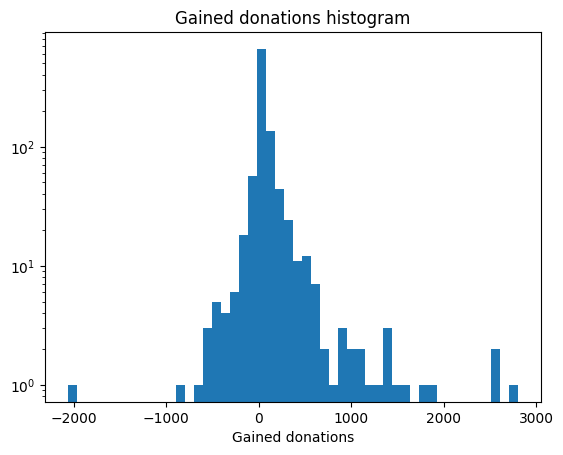

Average amount of donations gained 73.94158415841584


In [ ]:
channel_subscribers = {}

# Go through every node in the graph and pull out any that are channels
for network in graphs:
  for node in network["graph"]:
    if network["graph"].out_degree(node) == 0:
      channel_subscribers[node] = []

# For every channel we'll go through and graph the total donations for a specific month and record it
for node, value in channel_subscribers.items():
  for network in graphs:
    # Check and my sure the value for .in_degree exists, if not then just set it to 0.
    if type(network["graph"].in_degree(node)) == nx.classes.reportviews.InDegreeView:
      value.append((network["date"], 0))
    else:
      value.append((network["date"], network["graph"].in_degree(node)))

delta_subscribers = {}

# Here we're calculating the difference between the donations of the first month and last month in the data set
for index, (node, value) in enumerate(channel_subscribers.items()):

  # Sort all the points based on the date
  sorted_values = sorted(value, key=lambda tup: tup[0])

  delta_subscribers[node] = sorted_values[-1][1] - sorted_values[0][1]

top_10_gainers = sorted(delta_subscribers.items(), key=lambda item: item[1], reverse=True)[0:10]


print("###########")
print("Top 10 gainers")
print("###########")
for value in top_10_gainers:
  print(value[0] + ":" + str(value[1]))

plt.title("Gained donations histogram")
plt.hist(delta_subscribers.values(), bins=50)
plt.yscale("log")
plt.xlabel("Gained donations")
plt.show()

print("Average amount of donations gained", sum(delta_subscribers.values())/ len(delta_subscribers.values()))


# What are the patterns of donation behavior?

Community detection

In [ ]:
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities

#How long it took: 35 minutes

sc = dataset_converter('/content/superchats_2021-03.parquet')

sc['amount_in_usd'] = sc.apply(convert_to_usd, axis=1)

  # Round the 'amount_in_usd' column to 2 decimal places
sc['amount_in_usd'] = sc['amount_in_usd'].round(2)

G = create_graph(sc)

#UG = G.to_undirected()

communities = community.greedy_modularity_communities(G)


In [ ]:
num_communities = len(communities)

print(f"Number of communities: {num_communities}")

Number of communities: 42


In [ ]:
for index, community in enumerate(communities):
  #print(community)
  community_total = 0
  for node in community:
    #print(node)
    for edge in G.out_edges(node):
      community_total += G[edge[0]][edge[1]]["weight"]
  #print(index, community_total)
  print("Community:" + str(index) + " $" + str(community_total))

Community:0 $406916.34999999974
Community:1 $183783.89999999557
Community:2 $213505.62999999884
Community:3 $83703.33999999936
Community:4 $52573.6299999997
Community:5 $43732.76999999994
Community:6 $31270.640000000054
Community:7 $22384.64000000003
Community:8 $14906.310000000036
Community:9 $21462.480000000007
Community:10 $26146.650000000034
Community:11 $27707.690000000017
Community:12 $19228.64000000002
Community:13 $12735.050000000008
Community:14 $16752.15
Community:15 $8292.349999999991
Community:16 $13139.890000000012
Community:17 $9871.5
Community:18 $9962.190000000004
Community:19 $6316.6200000000035
Community:20 $1986.1899999999994
Community:21 $2351.7299999999987
Community:22 $3483.37
Community:23 $2507.5399999999995
Community:24 $816.3599999999994
Community:25 $866.21
Community:26 $1256.3799999999997
Community:27 $662.7699999999999
Community:28 $432.6199999999999
Community:29 $81.38
Community:30 $335.63
Community:31 $743.6400000000001
Community:32 $278.35
Community:33 $8

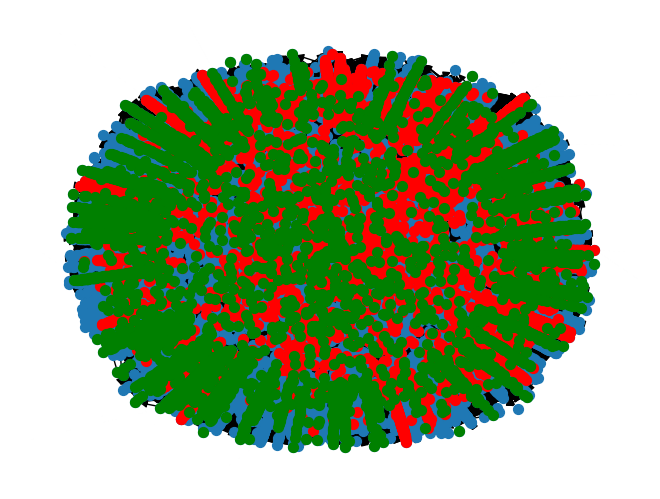

In [ ]:
pos = nx.spring_layout(G)
#edge_labels = nx.get_edge_attributes(test_graph, 'weight')  # Get edge attributes (weights)
nx.draw(G, pos, edge_color="k", node_size=50)
#nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

nx.draw_networkx_nodes(G, pos, nodelist=list(comp[0]), node_size=50, node_color="r")
nx.draw_networkx_nodes(G, pos, nodelist=list(comp[1]), node_size=50, node_color="g")

# What is the impact of large donations on channel growth?

In [ ]:
donations = sorted(channel_subscribers.items(), key=lambda item: item[1], reverse=True)

print(donations)

[('UCS9uQI-jC3DE0L4IpXyvr6w', [(datetime.date(2021, 3, 1), 2067), (datetime.date(2021, 4, 1), 4065), (datetime.date(2021, 5, 1), 3284)]), ('UC1DCedRgGHBdm81E1llLhOQ', [(datetime.date(2021, 3, 1), 1153), (datetime.date(2021, 4, 1), 1747), (datetime.date(2021, 5, 1), 2544)]), ('UCoSrY_IQQVpmIRZ9Xf-y93g', [(datetime.date(2021, 3, 1), 1088), (datetime.date(2021, 4, 1), 1952), (datetime.date(2021, 5, 1), 2448)]), ('UCFKOVgVbGmX65RxO3EtH3iw', [(datetime.date(2021, 3, 1), 1043), (datetime.date(2021, 4, 1), 1579), (datetime.date(2021, 5, 1), 1917)]), ('UCvzGlP9oQwU--Y0r9id_jnA', [(datetime.date(2021, 3, 1), 1042), (datetime.date(2021, 4, 1), 1684), (datetime.date(2021, 5, 1), 2117)]), ('UCHsx4Hqa-1ORjQTh9TYDhww', [(datetime.date(2021, 3, 1), 1000), (datetime.date(2021, 4, 1), 1398), (datetime.date(2021, 5, 1), 2108)]), ('UCqm3BQLlJfvkTsX_hvm0UmA', [(datetime.date(2021, 3, 1), 985), (datetime.date(2021, 4, 1), 1431), (datetime.date(2021, 5, 1), 2295)]), ('UCCzUftO8KOVkV4wQG1vkUvg', [(datetime.d

# Gephi

In [ ]:
# Read a Parquet file into a Pandas DataFrame
df = pd.read_parquet('/content/superchats_2021-03.parquet', engine='pyarrow')

# Save the DataFrame to a CSV file named "edges.csv"
df.to_csv('edges.csv', index=False)

In [ ]:
# Read the edges data from a CSV file into a Pandas DataFrame
edges_df = pd.read_csv('edges-superchat.csv')

# Extract unique nodes from the 'Source' and 'Target' columns of the edges DataFrame
unique_nodes = pd.unique(edges_df[['Source', 'Target']].values.ravel())

# Create a new DataFrame for nodes, with each unique node as an entry in the "Id" column
nodes_df = pd.DataFrame(unique_nodes, columns=["Id"])

# Create a "Label" column, assigning each node's ID as its label
nodes_df["Label"] = nodes_df["Id"]

# Save the nodes DataFrame to a CSV file named 'nodes.csv'
nodes_df.to_csv("nodes.csv", index=False)


# PROTOTYPE

In [ ]:
def the_analyzer_3000(Data):

  from networkx.algorithms import community # Import community detection algorithms from NetworkX, its already imported but bug apears if I dont type inside functoin

  # Convert the input data into a DataFrame using previosu function
  sc = dataset_converter(Data)

  # Apply the conversion to each row in the DataFrame and store the result in a new column
  sc['amount_in_usd'] = sc.apply(convert_to_usd, axis=1)

  # Round the 'amount_in_usd' column to 2 decimal places
  sc['amount_in_usd'] = sc['amount_in_usd'].round(2)

  # Create a directed graph from the processed dataset
  graph = create_graph(sc)

  # Printed input data name for clarity
  print('Data:', {Data})

  print()

  # Identify the top 10 candidates for influencers and printing them out
  best_in_candidate_streamer = top_in_candidate(graph)
  print("Top 10 influencers candidate:")
  print(*best_in_candidate_streamer, sep='\n')

  print()

  # Get the in-degree (number of donations received) of the top influencer candidate
  top_in = graph.in_degree(best_in_candidate_streamer[0])

  print(f"Top influencers based of the number of earned donations: {top_in}\n")

  # Calculate the total amount of donations received by the top influencer candidate
  total_in_amount = sum(data['weight'] for _, _, data in graph.in_edges(best_in_candidate_streamer[0], data=True))
  print(f'Total amount of earned US money from donation: {round(total_in_amount, 2)}\n')

  # Identify the top 10 candidates for donors based on out_degree
  best_out_candidate_streamer = top_out_candidate(graph)
  print("Top 10 donators candidate:")
  print(*best_out_candidate_streamer, sep='\n')

  print()

  # Get the out-degree (number of donations made) of the top donor candidate
  top_out = graph.out_degree(best_out_candidate_streamer[0])

  print(f"Top Donator based of total number of donations: {top_out}\n")

  # Calculate the total amount of donations made by the top donor candidate
  total_out_amount = sum(data['weight'] for _, _, data in graph.out_edges(best_out_candidate_streamer[0], data=True))
  print(f'Total amount US money they donated: {round(total_out_amount, 2)}\n')

  return


'''

  Hoped top have implemented community d3etection but time didnt allow for it

  communities = community.greedy_modularity_communities(graph)

  num_communities = len(communities)

  print(f"Number of communities: {num_communities} \n")


  for index, community in enumerate(communities):
  #print(community)
    community_total = 0
    for node in community:
      #print(node)
      for edge in G.out_edges(node):
        community_total += G[edge[0]][edge[1]]["weight"]
    #print(index, community_total)
    print("Community:" + str(index) + " $" + str(community_total))

'''

# Temporal Analysis

In [ ]:
the_analyzer_3000("superchats_2021-03.parquet")

Data: {'superchats_2021-03.parquet'}

Top 10 influencers candidate:
('UCS9uQI-jC3DE0L4IpXyvr6w', 0.054090124038310566)
('UC1DCedRgGHBdm81E1llLhOQ', 0.030172188203276287)
('UCoSrY_IQQVpmIRZ9Xf-y93g', 0.028471240906474068)
('UCFKOVgVbGmX65RxO3EtH3iw', 0.027293662008687915)
('UCvzGlP9oQwU--Y0r9id_jnA', 0.02726749358873711)
('UCHsx4Hqa-1ORjQTh9TYDhww', 0.026168419950803372)
('UCqm3BQLlJfvkTsX_hvm0UmA', 0.02577589365154132)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.025723556811639712)
('UCL_qhgtOy0dy1Agp8vkySQg', 0.02436279897419794)
('UC1CfXB_kRs3C-zaeTG3oGyg', 0.023473072695870623)

Top influencers based of the number of earned donations: [('UCS9uQI-jC3DE0L4IpXyvr6w', 2067)]

Total amount of earned US money from donation: 87593.08

Top 10 donators candidate:
('358aaddc52d77d586905d46da9fcc644ca72e75e', 0.001203747317736955)
('0d520b71c0fc01b9302d70ce21e15d14b051e039', 0.0005757052389176742)
('c1b69e599e63ef6c16fdb024be82317376d043df', 0.0005495368189668708)
('862f85a29fa903de2e3aa58497e166d136874e49

In [ ]:
the_analyzer_3000("superchats_2021-04.parquet")

Data: {'superchats_2021-04.parquet'}

Top 10 influencers candidate:
('UCS9uQI-jC3DE0L4IpXyvr6w', 0.06250576621459544)
('UCAWSyEs_Io8MtpY3m-zqILA', 0.03916412953224468)
('UCL_qhgtOy0dy1Agp8vkySQg', 0.03910262324322662)
('UC-hM6YJuNYVAmUWxeIr9FeA', 0.0357659070639973)
('UCdyqAaZDKHXg4Ahi7VENThQ', 0.03370544638189255)
('UChAnqc_AY5_I3Px5dig3X1Q', 0.03344404465356583)
('UCl_gCybOJRIgOXw6Qb4qJzQ', 0.03239843774025895)
('UCvaTdHTWBGv3MKj3KVqJVCw', 0.03029184734139066)
('UCoSrY_IQQVpmIRZ9Xf-y93g', 0.030015069040809427)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.029353876433865365)

Top influencers based of the number of earned donations: [('UCS9uQI-jC3DE0L4IpXyvr6w', 4065)]

Total amount of earned US money from donation: 138889.46

Top 10 donators candidate:
('862f85a29fa903de2e3aa58497e166d136874e49', 0.0008457114739982164)
('86fc3699c144a81774bea74698ad3a9e74236238', 0.0007995817572346774)
('0dd1fd96cc090ec6640159a00e09b5f909217b61', 0.0005689331734169819)
('46ea0d73eabd6849f64834c0b7c8e815ffcb46b3', 0

In [ ]:
the_analyzer_3000("superchats_2021-05.parquet")

Data: {'superchats_2021-05.parquet'}

Top 10 influencers candidate:
('UCS9uQI-jC3DE0L4IpXyvr6w', 0.04514896132642259)
('UCMwGHR0BTZuLsmjY_NT5Pwg', 0.043732900724528095)
('UC1DCedRgGHBdm81E1llLhOQ', 0.034975322050675724)
('UCoSrY_IQQVpmIRZ9Xf-y93g', 0.03365549857706532)
('UCqm3BQLlJfvkTsX_hvm0UmA', 0.03155202991599874)
('UCl_gCybOJRIgOXw6Qb4qJzQ', 0.030328443570672423)
('UCvzGlP9oQwU--Y0r9id_jnA', 0.02910485722534611)
('UCHsx4Hqa-1ORjQTh9TYDhww', 0.028981123774695135)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.02746882604451655)
('UCFKOVgVbGmX65RxO3EtH3iw', 0.026355224988657767)

Top influencers based of the number of earned donations: [('UCS9uQI-jC3DE0L4IpXyvr6w', 3284)]

Total amount of earned US money from donation: 115477.02

Top 10 donators candidate:
('862f85a29fa903de2e3aa58497e166d136874e49', 0.0007561488650892944)
('0dd1fd96cc090ec6640159a00e09b5f909217b61', 0.0007424007039058526)
('66254d57898df10ba1eb18d2918ecdd6a1791bc5', 0.0005361782861542269)
('46ea0d73eabd6849f64834c0b7c8e815ffcb46b3

In [ ]:
the_analyzer_3000("superchats_2021-06.parquet")

Data: {'superchats_2021-06.parquet'}

Top 10 influencers candidate:
('UCS9uQI-jC3DE0L4IpXyvr6w', 0.14224629069211828)
('UC_a1ZYZ8ZTXpjg9xUY9sj8w', 0.059005868731545355)
('UC6wvdADTJ88OfIbJYIpAaDA', 0.04779524375451794)
('UCoSrY_IQQVpmIRZ9Xf-y93g', 0.0356412109925385)
('UCqm3BQLlJfvkTsX_hvm0UmA', 0.03183082370526471)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.02580281552089587)
('UC1DCedRgGHBdm81E1llLhOQ', 0.025655790931033217)
('UCl_gCybOJRIgOXw6Qb4qJzQ', 0.022519266347296587)
('UCuvk5PilcvDECU7dDZhQiEw', 0.021906663889535525)
('UCAWSyEs_Io8MtpY3m-zqILA', 0.01990957987723447)

Top influencers based of the number of earned donations: [('UCS9uQI-jC3DE0L4IpXyvr6w', 11610)]

Total amount of earned US money from donation: 454049.04

Top 10 donators candidate:
('0dd1fd96cc090ec6640159a00e09b5f909217b61', 0.0004410737695879636)
('c1b69e599e63ef6c16fdb024be82317376d043df', 0.0004410737695879636)
('46ea0d73eabd6849f64834c0b7c8e815ffcb46b3', 0.0004043176221223)
('9f96733f2d10804774f6043430a57c46a5c56910', 0

In [ ]:
the_analyzer_3000("superchats_2021-07.parquet")

Data: {'superchats_2021-07.parquet'}

Top 10 influencers candidate:
('UCS9uQI-jC3DE0L4IpXyvr6w', 0.10532294899572524)
('UCmZ1Rbthn-6Jm_qOGjYsh5A', 0.043555659659190726)
('UCqm3BQLlJfvkTsX_hvm0UmA', 0.03258183521695848)
('UCZlDXzGoo7d44bwdNObFacg', 0.03182057738478655)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.03168003747730866)
('UCspv01oxUFf_MTSipURRhkA', 0.028658429466533932)
('UCl_gCybOJRIgOXw6Qb4qJzQ', 0.026737717397669378)
('UCRm6lqtdxs_Qo6HeL-SRQ-w', 0.025531416525150785)
('UC1DCedRgGHBdm81E1llLhOQ', 0.025437723253498856)
('UC-hM6YJuNYVAmUWxeIr9FeA', 0.024044035837676406)

Top influencers based of the number of earned donations: [('UCS9uQI-jC3DE0L4IpXyvr6w', 8993)]

Total amount of earned US money from donation: 220902.95

Top 10 donators candidate:
('c1b69e599e63ef6c16fdb024be82317376d043df', 0.0004684663582596475)
('5573cea30cb96fe62bf97302b260e868653345f8', 0.0004333313813901739)
('2bd4e65a27f526d7cf342621c88902992db83bc8', 0.0004333313813901739)
('0d520b71c0fc01b9302d70ce21e15d14b051e03

In [ ]:
the_analyzer_3000("superchats_2021-08.parquet")

Data: {'superchats_2021-08.parquet'}

Top 10 influencers candidate:
('UC-6rZgmxZSIbq786j3RD5ow', 0.03212190332859108)
('UC9ruVYPv7yJmV0Rh0NKA-Lw', 0.031898507954051095)
('UCgmFrRcyH7d1zR9sIVQhFow', 0.030087829655148085)
('UCl_gCybOJRIgOXw6Qb4qJzQ', 0.0243618534761496)
('UCFKOVgVbGmX65RxO3EtH3iw', 0.022692266992745527)
('UCuep1JCrMvSxOGgGhBfJuYw', 0.022174930335916096)
('UCp-5t9SrOQwXMU7iIjQfARg', 0.021445955955838262)
('UC-hM6YJuNYVAmUWxeIr9FeA', 0.02057588976026149)
('UCAWSyEs_Io8MtpY3m-zqILA', 0.020281948477972038)
('UCCzUftO8KOVkV4wQG1vkUvg', 0.017965691173531174)

Top influencers based of the number of earned donations: [('UC-6rZgmxZSIbq786j3RD5ow', 2732)]

Total amount of earned US money from donation: 88058.29

Top 10 donators candidate:
('2bd4e65a27f526d7cf342621c88902992db83bc8', 0.0006937014262031016)
('0d520b71c0fc01b9302d70ce21e15d14b051e039', 0.00042327544649680776)
('0dd1fd96cc090ec6640159a00e09b5f909217b61', 0.0003762448413304958)
('46ea0d73eabd6849f64834c0b7c8e815ffcb46b